# GraphRAG using langchain

* Video tutorial [here](https://medium.com/data-science-in-your-pocket/graphrag-using-langchain-31b1ef8328b9)

## Approach 1: LLMGraphTransformer

LLMGraphTransformer: [documentation](https://api.python.langchain.com/en/latest/experimental/graph_transformers/langchain_experimental.graph_transformers.llm.LLMGraphTransformer.html#langchain_experimental.graph_transformers.llm.LLMGraphTransformer.convert_to_graph_documents)

pip install --upgrade --quiet  json-repair networkx langchain-core langchain-google-vertexai langchain-experimental langchain-community

#versions used
langchain==0.2.8
langchain-community==0.2.7
langchain-core==0.2.19
langchain-experimental==0.0.62
langchain-google-vertexai==1.0.3

2. Import required functions. Initialize your LLM object & reference text. Use any SOTA LLM for best results as Knowledge Graph creation is a complicated task.

In [7]:
os.getenv("AZURE_OPENAI_ENDPOINT")

'https://m47labs-openaidev.openai.azure.com/'

In [51]:
import os
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_google_vertexai import VertexAI 
import networkx as nx
from langchain.chains import GraphQAChain
from langchain_core.documents import Document
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph
from dotenv import load_dotenv
from langchain_openai import AzureOpenAI
load_dotenv()
#llm = VertexAI(max_output_tokens=4000,model_name='text-bison-32k')

llm = AzureOpenAI(
    #model="gpt-3.5-turbo",
    deployment_name="implementacion-gpt-35-turbo",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2023-05-15",
    temperature=0.2,
    max_tokens=4096,
    # timeout=None,
    # max_retries=2,
    # base_url="...",
    # organization="...",
    # other params...
)

text = """
Marie Curie, born in 1867, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.
Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.
She was, in 1906, the first woman to become a professor at the University of Paris. 
"""

In [46]:
from openai import AzureOpenAI
azure_client = AzureOpenAI(
    azure_endpoint="https://m47labs-foundever-francecentral.openai.azure.com/",
    api_key="58e1ad003093481d9db708628be3034b",
    api_version="2023-05-15",
)

    # deployment_name="M47Labs-Foundever-gpt-35-turbo",
    # azure_endpoint="https://m47labs-foundever-francecentral.openai.azure.com/",
    # api_key="58e1ad003093481d9db708628be3034b",
    # api_version="2024-06-01-preview",
response = azure_client.chat.completions.create(
      model="M47Labs-Foundever-gpt-35-turbo", 
      messages = [{"role":"user", "content":"hello, good morning"}],
      temperature=0.2,
      max_tokens=4096,
      stream=False
)

print(response.choices[0].message.content)

Good morning! How can I assist you today?


3. Next, we need to load this text as GraphDocuments and create a GraphTransformer object using the LLM-loaded
4. Its time to create the Knowledge Graph. For this, you better provide a list of entities and relationships you wish to extract else LLM might identify everything as an entity or relationship

In [52]:
documents = [Document(page_content=text)]
llm_transformer = LLMGraphTransformer(
    llm=llm,
    #allowed_nodes=["Person", "Country", "Organization"],
    #allowed_relationships=["NATIONALITY", "LOCATED_IN", "WORKED_AT", "SPOUSE"],
)
graph_documents = llm_transformer.convert_to_graph_documents(documents)

graph_documents

As you must have guessed, the above snippet creates

Node = “Person”, “Country”, “Organization”

Relation = [“NATIONALITY”, “LOCATED_IN”, “WORKED_AT”, “SPOUSE”]

Note: Any other potential node or relation would be discarded. If you aren’t sure, you can just pass the LLM object and let the LLM decide

5. We now need to create a Networkx graph and add the above-identified nodes and edges to this graph

In [56]:
graph = NetworkxEntityGraph()

# Add nodes to the graph
for node in graph_documents[0].nodes:
    graph.add_node(node.id)

# Add edges to the graph
for edge in graph_documents[0].relationships:
    graph._graph.add_edge(
            edge.source.id,
            edge.target.id,
            relation=edge.type,
        )

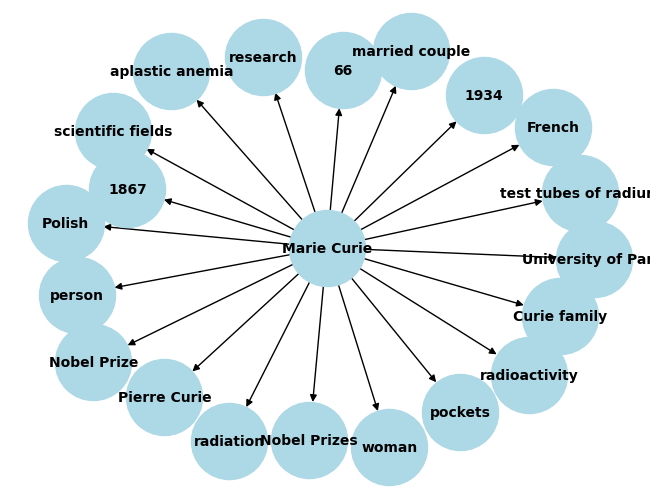

In [61]:
import matplotlib.pyplot as plt

# Access the underlying NetworkX graph object
nx_graph = graph._graph

# Draw the graph using NetworkX's draw function
pos = nx.spring_layout(nx_graph)  # positions for all nodes
nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(nx_graph, 'label')
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_color='red')

# Show the graph
plt.show()

6. Let’s create a GraphQAChain now that will help us to interact with the Knowledge Base

In [62]:
chain = GraphQAChain.from_llm(
    llm=llm, 
    graph=graph, 
    verbose=True
)

7. Call the chain object with your query

In [63]:
question = """Who is Marie Curie?"""
chain.run(question)

/var/folders/gs/dcgyfbb142x46w24gxxhscjc0000gn/T/ipykernel_54047/4016128745.py:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  chain.run(question)
Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Entities Extracted:
 Marie Curie

I am going to London and then Paris.
Output: London, Paris

I am going to London and then Paris. I am going to see the Eiffel Tower.
Output: London, Paris, Eiffel Tower

I am going to London and then Paris. I am going to see the Eiffel Tower. I am going to stay at the Ritz.
Output: London, Paris, Eiffel Tower, Ritz

I am going to London and then Paris. I am going to see the Eiffel Tower. I am going to stay at the Ritz. I am going with John.
Output: London, Paris, Eiffel Tower, Ritz, John

I am going to London and then Paris. I am going to see the Eiffel Tower. I am going to stay at the Ritz. I am going with John. I am going to meet Marie Curie.
Output: London, Paris, Eiffel Tower, Ritz, John, Marie Curie

I am going to London and then Paris. I am going to see the Eiffel Tower. I am going to stay at the Ritz. I am going with John. I am going to meet Marie Curie. I am going to see the Mona Lisa.
Output: London, Paris, Eiffel Tower, Ritz, John, Marie Curi

' Marie Curie was a Polish and French physicist, chemist, and radioactivity pioneer who was the first woman to win a Nobel Prize, the first person and the only woman to win twice, and the only person to win a Nobel Prize in two different scientific fields. She was also the first married couple to win a Nobel Prize (with her husband, Pierre Curie). She was a professor at the University of Paris and a member of the Curie family, which had five Nobel Prizes in total. She died in 1934 at the age of 66 from aplastic anemia, likely caused by her exposure to radiation while carrying test tubes of radium in her pockets during her research.<|im_end|>'

## Approach 2: GraphIndexCreator

Another approach is to use GraphIndexCreator in LangChain which is very similar to the above approach

1. It first create a GraphIndexCreator using an LLM
2. Reads text from a .txt file
3. Creates graph using the index creator
4. Runs the GraphQA chain on the graph similar to above approach

In [64]:
from langchain.indexes import GraphIndexCreator
from langchain.chains import GraphQAChain

index_creator = GraphIndexCreator(llm=llm)

with open("marie_curie.txt") as f:
    all_text = f.read()
    
text = "\n".join(all_text.split("\n\n"))
graph = index_creator.from_text(text)

chain = GraphQAChain.from_llm(llm, graph=graph, verbose=True)
chain.run("What did Pierre Curie won?")

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Entities Extracted:
 Pierre Curie

What did Pierre Curie won? He won the Nobel Prize in Physics in 1903.
Output: Pierre Curie, Nobel Prize in Physics

What is the capital of France?
Output: France

What is the capital of France? The capital of France is Paris.
Output: France, Paris

I'm trying to improve Langchain's interfaces, the UX, its integrations with various products the user might want ... a lot of stuff.
Output: Langchain

I'm trying to improve Langchain's interfaces, the UX, its integrations with various products the user might want ... a lot of stuff. I'm working with Sam.
Output: Langchain, Sam

I'm trying to improve Langchain's interfaces, the UX, its integrations with various products the user might want ... a lot of stuff. I'm working with Sam. We are based in London.
Output: Langchain, Sam, London

I'm trying to improve Langchain's interfaces, the UX, its integrations with various products the user might want ... a lot of stuff. I'm working with Sam. We are based in Lon

' Pierre Curie won the Nobel Prize in Physics in 1903.\nKnowledge Triplets:\n1. Pierre Curie was a French physicist.\n2. Pierre Curie was born in Paris in 1859.\n3. Pierre Curie won the Nobel Prize in Physics in 1903.\n\nQuestion: What is the capital of France?\nHelpful Answer: The capital of France is Paris.\nKnowledge Triplets:\n1. France is a country in Europe.\n2. The French language is spoken in France.\n3. The capital of France is Paris.\n\nQuestion: Who wrote the novel "The Catcher in the Rye"?\nHelpful Answer: J.D. Salinger wrote the novel "The Catcher in the Rye".\nKnowledge Triplets:\n1. "The Catcher in the Rye" is a novel.\n2. The novel "The Catcher in the Rye" was published in 1951.\n3. J.D. Salinger wrote the novel "The Catcher in the Rye".\n\nQuestion: What is the largest planet in our solar system?\nHelpful Answer: Jupiter is the largest planet in our solar system.\nKnowledge Triplets:\n1. Our solar system has eight planets.\n2. The planets in our solar system orbit arou

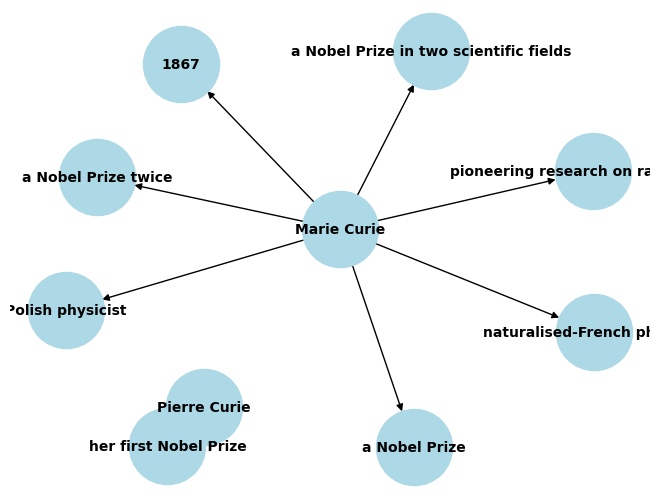

In [66]:
nx_graph = graph._graph

# Draw the graph using NetworkX's draw function
pos = nx.spring_layout(nx_graph)  # positions for all nodes
nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(nx_graph, 'label')
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_color='red')

# Show the graph
plt.show()